In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Especificando cada caminho

In [2]:
dataset = 'model/rotation_history_classifier/rotation_history.csv'
model_save_path = 'model/rotation_history_classifier/rotation_history_classifier.keras'

# Número de Rotações Classificadas

In [3]:
NUM_CLASSES = 3
TIME_STEPS = 16
DIMENSION = 2

# Carregar dados de aprendizagem

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Construindo modelo

In [7]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

C:\Users\arthurmacedo-ieg\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075 (4.20 KB)

 Trainable params: 1,075 (4.20 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento do Modelo

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 78/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4175 - loss: 1.0939
Epoch 1: saving model to model/rotation_history_classifier/rotation_history_classifier.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4410 - loss: 1.0883 - val_accuracy: 0.5795 - val_loss: 1.0455
Epoch 2/1000
 98/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5645 - loss: 1.0273
Epoch 2: saving model to model/rotation_history_classifier/rotation_history_classifier.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5663 - loss: 1.0234 - val_accuracy: 0.6023 - val_loss: 0.9576
Epoch 3/1000
 98/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5882 - loss: 0.9511
Epoch 3: saving model to model/rotation_history_classifier/rotation_history_classifier.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5904 - loss: 0.9484 - val_accuracy: 0.6253 - val_loss: 0.8854
Epoch 4/1000
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 0.8989
Epoch 4: saving mo

In [12]:
model = tf.keras.models.load_model(model_save_path)

In [13]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[0.10010842 0.7570461  0.14284547]
1


# Matriz de confusão

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


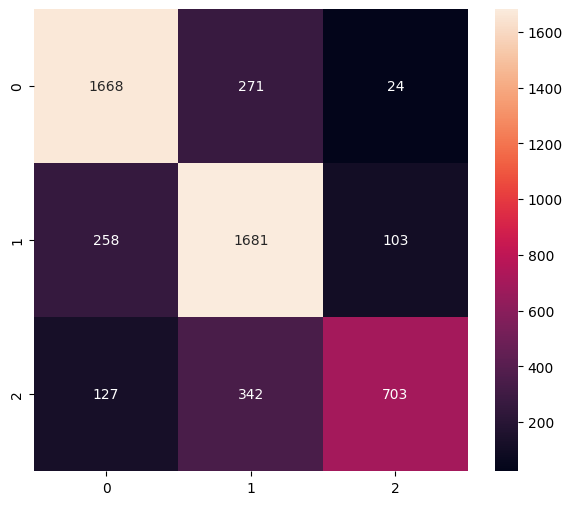

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1963
           1       0.73      0.82      0.78      2042
           2       0.85      0.60      0.70      1172

    accuracy                           0.78      5177
   macro avg       0.80      0.76      0.77      5177
weighted avg       0.79      0.78      0.78      5177



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite

In [15]:
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [16]:
tflite_save_path = 'model/rotation_history_classifier/rotation_history_classifier.tflite'

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ARTHUR~1\AppData\Local\Temp\tmpcaaj9buf\assets


INFO:tensorflow:Assets written to: C:\Users\ARTHUR~1\AppData\Local\Temp\tmpcaaj9buf\assets


Saved artifact at 'C:\Users\ARTHUR~1\AppData\Local\Temp\tmpcaaj9buf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1628100584912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1628100585872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1628100586064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1628100587024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1628100587216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1628100587984: TensorSpec(shape=(), dtype=tf.resource, name=None)


6380

# Teste de raciocínio

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.10010844 0.7570461  0.14284548]
1
